# Zillow Regression Project

<img src="zillow_logo.png" title="telco_logo" width="400" height="200" />

In [1]:
import pandas as pd
import numpy as np
import os
from env import host, user, password
import acquire
import explore
import prepare

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import wrangle_zillow as wr

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import warnings
warnings.filterwarnings("ignore")




## Project Goals

> - Find drivers for taxvalue using Zillow data. What affects taxvalue?

> - Construct an ML Regression model that beats the baseline in predicting taxvalue.

> - Determine state, county, and tax rate.

## Executive Summary 

> - Bedroom count, bathroom count, and area(sqft) all have a linear correlation with taxvalue.
> - Our best model (Quadratic Polynomial) beat our baseline (mean) RMSE value by 12,259.
> - Single Unit Properties assessed from May-Aug 2017 found in the Zillow dataset were located in the following counties: Orange, Ventura, Los Angeles. All in the state of California.


# Acquire and Prep Data

In [2]:
df = wr.wrangle_zillow()
df.head()

,yearbuilt,taxamount,fips,area,bed,bath,taxvalue,tdate_month,tdate_day,tdate_week,county,taxrate
578,1974.0,3490.16,6059.0,1125.0,3.0,2.0,289445.0,8,4,31,Orange,0.012058
950,1923.0,2627.48,6037.0,1316.0,3.0,2.0,205123.0,7,21,29,Los Angeles,0.012809
1163,1970.0,2319.90,6037.0,1458.0,3.0,2.0,136104.0,6,23,25,Los Angeles,0.017045
2494,1955.0,1399.27,6037.0,1491.0,3.0,2.0,107110.0,8,23,34,Los Angeles,0.013064
3051,1949.0,7673.19,6037.0,1650.0,3.0,2.0,614000.0,6,1,22,Los Angeles,0.012497


In [3]:
df.shape

(24465, 12)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
yearbuilt,24465.0,1972.063356,19.275896,1878.000000,1958.000000,1973.000000,1986.000000,2016.000000
taxamount,24465.0,4242.993135,2070.649245,51.260000,2635.820000,4091.920000,5705.510000,9030.860000
fips,24465.0,6051.353076,22.332607,6037.000000,6037.000000,6037.000000,6059.000000,6111.000000
area,24465.0,1586.926466,442.213607,542.000000,1248.000000,1510.000000,1861.000000,2799.000000
bed,24465.0,3.017821,0.799828,1.000000,2.000000,3.000000,4.000000,5.000000
bath,24465.0,2.288841,0.447846,1.500000,2.000000,2.000000,2.500000,3.500000
taxvalue,24465.0,345473.229839,183367.947655,17032.000000,199567.000000,333593.000000,472093.000000,837745.000000
tdate_month,24465.0,6.464255,1.110900,5.000000,5.000000,6.000000,7.000000,8.000000
tdate_day,24465.0,17.178663,9.060282,1.000000,9.000000,17.000000,25.000000,31.000000
tdate_week,24465.0,26.403311,5.112596,18.000000,22.000000,26.000000,31.000000,35.000000


In [5]:
df.groupby('county').taxrate.describe()

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
Los Angeles,14349.0,0.013680,0.003479,0.000857,0.012142,0.012585,0.014037,0.142742
Orange,7643.0,0.012025,0.002493,0.001449,0.010450,0.011636,0.012604,0.107350
Ventura,2473.0,0.011686,0.002351,0.000787,0.010701,0.011293,0.011878,0.062454


In [6]:
df.groupby('county').taxrate.median()

county
Los Angeles    0.012585
Orange         0.011636
Ventura        0.011293
Name: taxrate, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24465 entries, 578 to 67826
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   yearbuilt    24465 non-null  float64
 1   taxamount    24465 non-null  float64
 2   fips         24465 non-null  float64
 3   area         24465 non-null  float64
 4   bed          24465 non-null  float64
 5   bath         24465 non-null  float64
 6   taxvalue     24465 non-null  float64
 7   tdate_month  24465 non-null  int64  
 8   tdate_day    24465 non-null  int64  
 9   tdate_week   24465 non-null  int64  
 10  county       24465 non-null  object 
 11  taxrate      24465 non-null  float64
dtypes: float64(8), int64(3), object(1)
memory usage: 2.4+ MB


In [8]:
df.isna().sum()

yearbuilt      0
taxamount      0
fips           0
area           0
bed            0
bath           0
taxvalue       0
tdate_month    0
tdate_day      0
tdate_week     0
county         0
taxrate        0
dtype: int64

# Distribution Visualizations

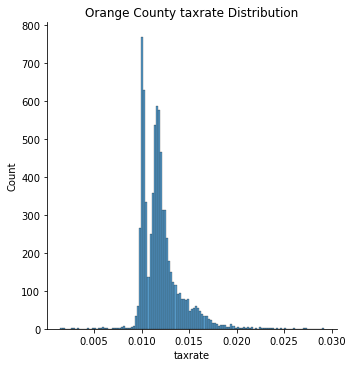

In [53]:
sns.displot(x='taxrate', data=df[(df.county == 'Orange')&(df.taxrate<0.03)])
plt.title('Orange County taxrate Distribution')
plt.show()

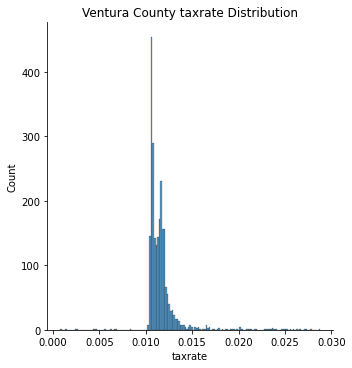

In [52]:
sns.displot(x='taxrate', data=df[(df.county == 'Ventura')&(df.taxrate<0.03)])
plt.title('Ventura County taxrate Distribution')
plt.show()

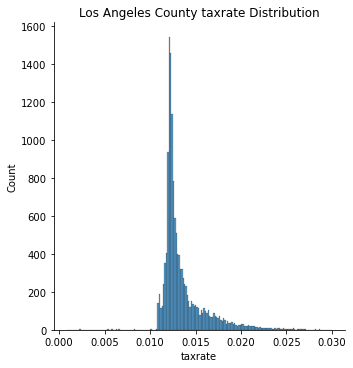

In [51]:
sns.displot(x='taxrate', data=df[(df.county == 'Los Angeles')&(df.taxrate<0.03)])
plt.title('Los Angeles County taxrate Distribution')
plt.show()

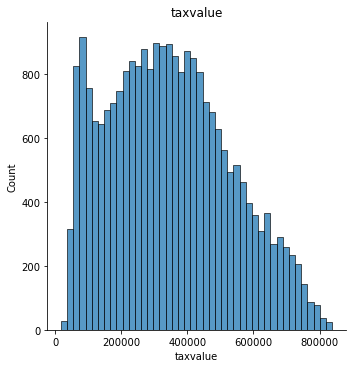

In [10]:
sns.displot(x='taxvalue', data=df)
plt.title('taxvalue')
plt.show()

<AxesSubplot:>

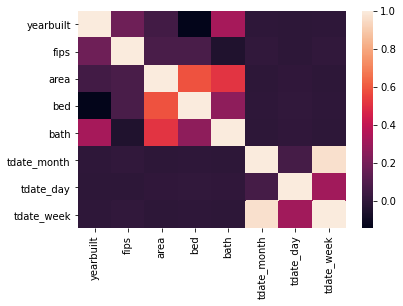

In [11]:
sns.heatmap(df.drop(columns=['taxvalue', 'taxamount', 'taxrate']).corr())

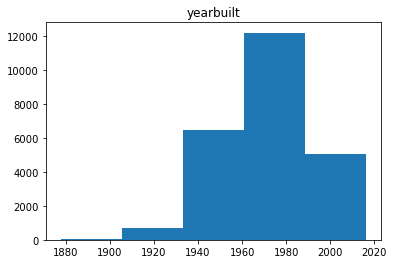

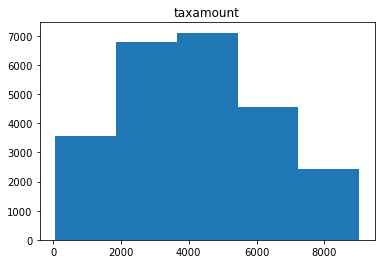

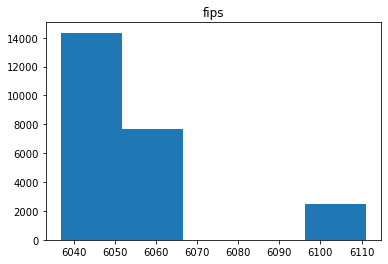

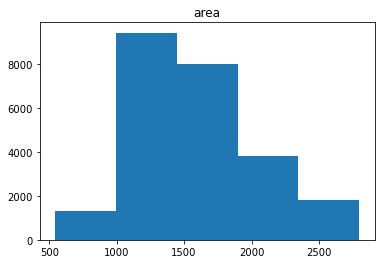

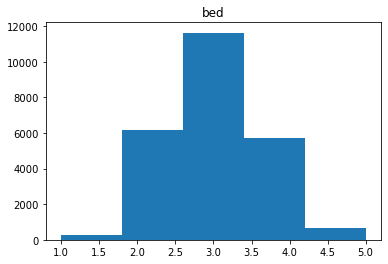

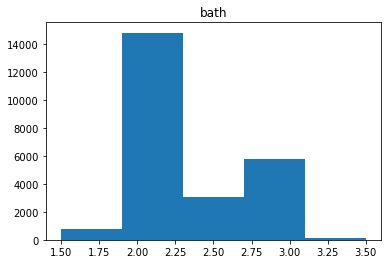

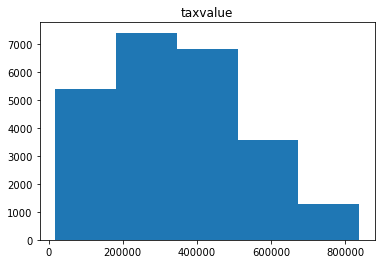

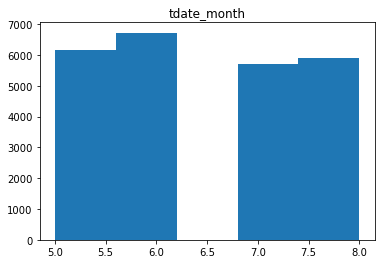

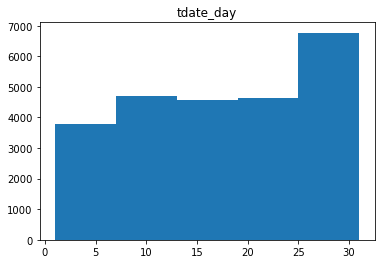

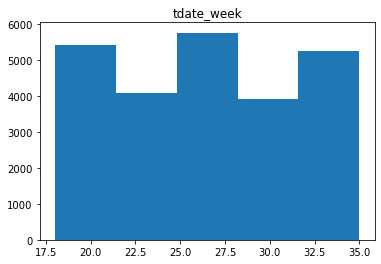

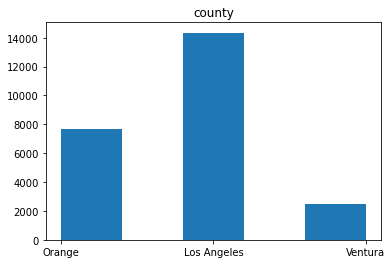

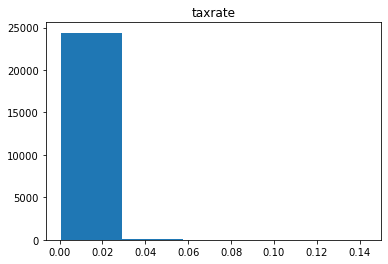

In [12]:
for i, col in enumerate(df.columns):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    #plt.subplot(1,12, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    plt.show()


<AxesSubplot:>

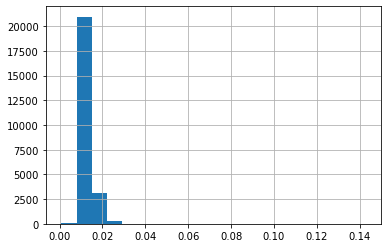

In [43]:
df.taxrate.hist(bins=20)

# Takeaways
 - Most of the homes assessed in 2017 were built in the late 60's, early 80's
 - Normal distribution for taxamount, taxvalue
 - A majority of the homes assess in 2017 were under 2000 sqft in area
 - Most popular homes had 3 bedrooms or 2 baths
 - Most of the homes assessed in 2017 were located in the Los Angeles county
 - Almost all taxrates were under 3%

# Split and Make Variables

In [14]:
train, validate, test = wr.split(df)
train.shape, validate.shape, test.shape

((13700, 12), (5872, 12), (4893, 12))

In [15]:
def make_vars():
    
    target = "taxvalue"
    clist = ['area', 'bed', 'bath']

    # split train into X (dataframe, only col in list) & y (series, keep target only)
    X_train = train[clist]
    y_train = train[target]
    y_train = pd.DataFrame(y_train)
    
    # split validate into X (dataframe, only col in list) & y (series, keep target only)
    X_validate = validate[clist]
    y_validate = validate[target]
    y_validate = pd.DataFrame(y_validate)

    # split test into X (dataframe, only col in list) & y (series, keep target only)
    X_test = test[clist]
    y_test = test[target]
    y_test = pd.DataFrame(y_test)
    
    return target, X_train, y_train, X_validate, y_validate, X_test, y_test

In [16]:
target, X_train, y_train, X_validate, y_validate, X_test, y_test = make_vars()
target, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

('taxvalue',
 (13700, 3),
 (13700, 1),
 (5872, 3),
 (5872, 1),
 (4893, 3),
 (4893, 1))

# Running Pearson's Correlation Coefficient Test On My Hypothesis

> - **Hypothesis 1 -**
> - alpha = .05
> - $H_0$: There is no linear correlation between bedroom count and taxvalue.  
> - $H_a$: There is a linear correlation between bedroom count and taxvalue. 
> - Outcome: I rejected the Null Hypothesis; Therefore we reject that there is no linear correlation between bedroom count and taxvalue.

In [17]:
a = 0.05

<AxesSubplot:xlabel='bed', ylabel='taxvalue'>

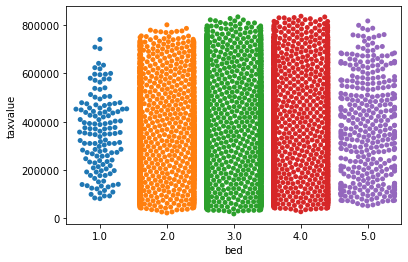

In [18]:
sns.swarmplot(x='bed', y='taxvalue', data=train)

In [19]:
corr, p = stats.pearsonr(train.bed, train.taxvalue)
corr, p

(0.06418751631879778, 5.476546752535778e-14)

In [20]:
if p < a:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypthesis")

We reject the null hypothesis


 p is less than a, so we reject our null hypothesis that there is no linear correlation between bedroom count and taxvalue. 

> - **Hypothesis 2 -**
> - alpha = .05
> - $H_0$: There is no linear correlation between bathroom count and taxvalue.  
> - $H_a$: There is a linear correlation between bathroom count and taxvalue. 
> - Outcome: I rejected the Null Hypothesis; Therefore we reject that there is no linear correlation between bathroom count and taxvalue.

In [21]:
a = 0.05

<AxesSubplot:xlabel='bath', ylabel='taxvalue'>

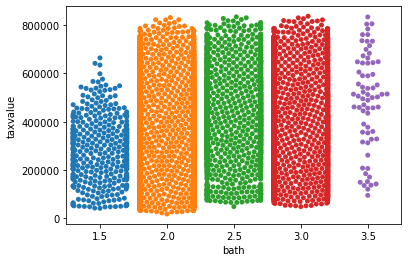

In [22]:
sns.swarmplot(x='bath', y='taxvalue', data=train)

In [23]:
corr, p = stats.pearsonr(train.bath, train.taxvalue)
corr, p

(0.21554355792937024, 9.878613606727226e-144)

In [24]:
if p < a:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypthesis")

We reject the null hypothesis


p is less than a, so we reject our null hypothesis that there is no linear correlation between bathroom count and taxvalue. 

> - **Hypothesis 3 -**
> - alpha = .05
> - $H_0$: There is no linear correlation between area and taxvalue.  
> - $H_a$: There is a linear correlation between area and taxvalue. 
> - Outcome: I rejected the Null Hypothesis; Therefore we reject that there is no linear correlation between area and taxvalue.

In [25]:
a = 0.05

<AxesSubplot:xlabel='area', ylabel='taxvalue'>

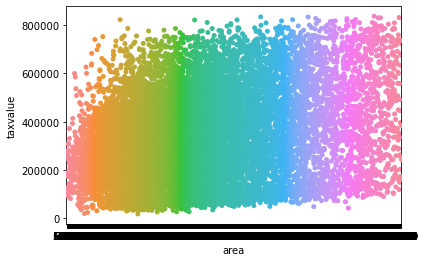

In [26]:
sns.swarmplot(x='area', y='taxvalue', data=train)

In [27]:
corr, p = stats.pearsonr(train.area, train.taxvalue)
corr, p

(0.27383049156074774, 3.586581114386044e-234)

In [28]:
if p < a:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypthesis")

We reject the null hypothesis


p is less than a, so we reject our null hypothesis that there is no linear correlation between area and taxvalue. 

# Modeling

## Baseline

In [29]:
# 1. Predict taxvalue_pred_mean
taxvalue_pred_mean = y_train.taxvalue.mean()
y_train['taxvalue_pred_mean'] = taxvalue_pred_mean
y_validate['taxvalue_pred_mean'] = taxvalue_pred_mean


# 2. compute taxvalue_pred_median
taxvalue_pred_median = y_train.taxvalue.median()
y_train['taxvalue_pred_median'] = taxvalue_pred_median
y_validate['taxvalue_pred_median'] = taxvalue_pred_median


# 3. RMSE of taxvalue_pred_mean
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_mean) ** (1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of taxvalue_pred_median
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_median) ** .5
print("\nRMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  183280.54 
Validate/Out-of-Sample:  184140.0

RMSE using Median
Train/In-Sample:  183608.5 
Validate/Out-of-Sample:  184669.37


My training sample mean has a lower RMSE value, so I will use that as my baseline.

In [30]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [31]:
metric_df = pd.DataFrame()
metric_df = make_metric_df(y_validate.taxvalue,
                           y_validate.taxvalue_pred_mean,
                           'mean_baseline',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,184139.996823,0.0


## OLS

In [32]:
def linear_regression():

    lm = LinearRegression(normalize=True)

    lm.fit(X_train, y_train.taxvalue)

    y_train['taxvalue_pred_lm'] = lm.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lm) ** (1/2)

    # predict validate
    y_validate['taxvalue_pred_lm'] = lm.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lm) ** (1/2)

    return print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
                  "\nValidation/Out-of-Sample: ", rmse_validate)

In [33]:
linear_regression()

RMSE for OLS using LinearRegression
Training/In-Sample:  174317.49944991924 
Validation/Out-of-Sample:  174258.34726592238


In [34]:
metric_df = make_metric_df(y_validate.taxvalue,
                           y_validate.taxvalue_pred_lm,
                           'OLS Regressor',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,184139.996823,0.000000
1,OLS Regressor,174258.347266,0.104487


## Lasso+Lars with alpha = 1

In [35]:
def lassolars(a):
    # given a for alpha
    
    # create the model object
    lars = LassoLars(alpha=a)

    # fit the model to our training data. We must specify the column in y_train, 
    # since we have converted it to a dataframe from a series!
    lars.fit(X_train, y_train.taxvalue)

    # predict train
    y_train['taxvalue_pred_lars'] = lars.predict(X_train)

    # evaluate: rmse
    rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lars) ** (1/2)

    # predict validate
    y_validate['taxvalue_pred_lars'] = lars.predict(X_validate)

    # evaluate: rmse
    rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lars) ** (1/2)

    return print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

In [36]:
lassolars(1)

RMSE for Lasso + Lars
Training/In-Sample:  174317.69682183256 
Validation/Out-of-Sample:  174260.48803471963


In [37]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lars,
               'lasso_alpha_1',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,184139.996823,0.000000
1,OLS Regressor,174258.347266,0.104487
2,lasso_alpha_1,174260.488035,0.104466


## Polynomial to the 2nd Degree

In [38]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)

In [39]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.taxvalue)

# predict train
y_train['taxvalue_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvalue, y_train.taxvalue_pred_lm2)**(1/2)

# predict validate
y_validate['taxvalue_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  173511.78370171433 
Validation/Out-of-Sample:  173763.3774131582


In [40]:
metric_df = make_metric_df(y_validate.taxvalue,
               y_validate.taxvalue_pred_lm2,
               'Polynomiald2',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,184139.996823,0.000000
1,OLS Regressor,174258.347266,0.104487
2,lasso_alpha_1,174260.488035,0.104466
3,Polynomiald2,173763.377413,0.109562


# Run Polynomiald2 on TEST

In [41]:
X_test_degree2 = pf.transform(X_test)

# predict validate
y_test['taxvalue_pred_lm2'] = lm2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.taxvalue, y_test.taxvalue_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\n", 
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=2
 
Test/Out-of-Sample:  171880.4532106671


In [42]:
metric_df = make_metric_df(y_test.taxvalue,
               y_test.taxvalue_pred_lm2,
               'Polynomiald2 on Test',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,184139.996823,0.000000
1,OLS Regressor,174258.347266,0.104487
2,lasso_alpha_1,174260.488035,0.104466
3,Polynomiald2,173763.377413,0.109562
4,Polynomiald2 on Test,171880.453211,0.114865


In [59]:
y_train.head()

,taxvalue,taxvalue_pred_mean,taxvalue_pred_median,taxvalue_pred_lm,taxvalue_pred_lars,taxvalue_pred_lm2
43129,310029.0,343838.291022,332869.0,419395.680664,418843.427629,407419.792489
47462,654241.0,343838.291022,332869.0,320832.090494,320920.241216,330188.050151
32794,154108.0,343838.291022,332869.0,285580.292382,285616.439077,276299.849908
51079,247358.0,343838.291022,332869.0,396725.529026,396510.368240,403987.965227
40814,329955.0,343838.291022,332869.0,298452.058303,298431.606547,297348.276464


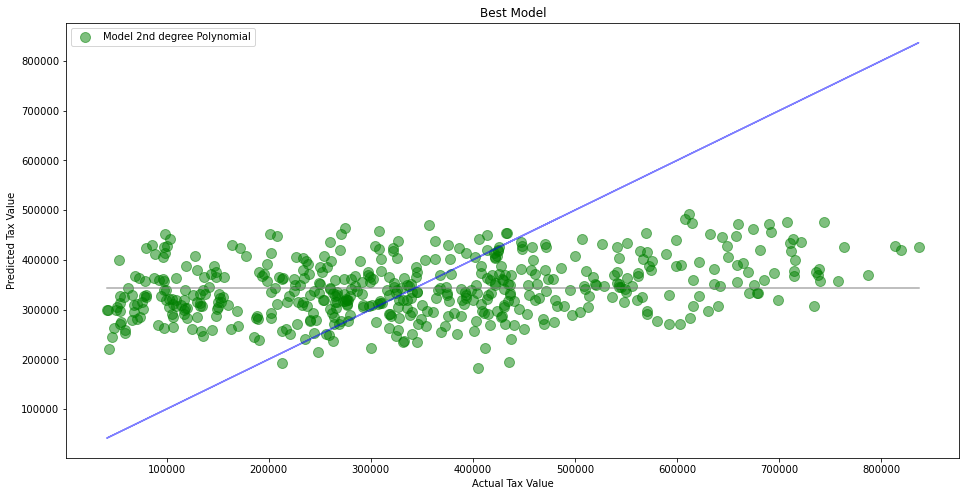

In [60]:
y_test_sample = y_test.sample(n=500)
y_train_sample = y_train.sample(n=500)


plt.figure(figsize=(16,8))
plt.plot(y_test_sample.taxvalue, y_train_sample.taxvalue_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_test_sample.taxvalue, y_test_sample.taxvalue, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_test_sample.taxvalue, y_test_sample.taxvalue_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Best Model")
plt.show()

# Summary

## Key Takeways
- Bedroom count, bathroom count, and area(sqft) all have a linear correlation with taxvalue
- Both taxvalue and taxamount have normal distributions
- Our best model (Quadratic Polynomial) beat our baseline (mean) RMSE value by 12,259.
- Single Unit Properties assessed from May-Aug 2017 found in the Zillow dataset were located in the following counties: Orange, Ventura, Los Angeles. All in the state of California.

## Recommendations
- Let's encourage clients to fillout as much of the data as possible. Many columns are missing rows and that affects predictability of a model.  
- The most popular homes had 3 bed, 2 bath, and were under 2000sqft. Perhaps by advertising these homes more heavily when they become available we might see an increase in transactions. 

## If given more time...
- I'd like to engineer new features that might give us an insight into why so many of these houses are located inside the Los Angeles county. 
- Try out different combinations of features that might produce a more accurate model. 